# Polarization reconstruction with neutrinos

### Dec 7, 2020

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util
from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
import pyrex.custom.ara as ara


Welcome to JupyROOT 6.18/04


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


## Events debugging

In [65]:
appended_data = []
import os
for filename in os.listdir("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/"):#Loop over desired directory
        if (filename.startswith("pol_quant_noiseless_")): #extension, .root in this case
            name = os.path.join("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/", str(filename))
            data = pd.read_pickle(name)
            appended_data.append(data)
recoNu = pd.concat(appended_data)     
# recoNu = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/debug/pol_quant_noiseless.pkl")
recoNu = recoNu.loc[recoNu.rmsV>50]
recoNu = recoNu.loc[recoNu.rmsV<1400]
recoNu = recoNu.loc[recoNu.rmsH>50]
recoNu = recoNu.loc[recoNu.rmsH<1400]
# recoNu = recoNu.loc[recoNu.theta_reco<np.pi/2+0.2]


array2 = []
R_True = []
R_Reco = []
propVec = []
dot = []
for i in recoNu.itertuples(): 
    thetaHat = np.array([np.cos(i.theta_reco)*np.cos(i.phi_reco), np.cos(i.theta_reco)*np.sin(i.phi_reco), -np.sin(i.theta_reco)])
    phiHat = np.array([-np.sin(i.phi_reco), np.cos(i.phi_reco),0])
    R_Reco.append(np.sqrt(i.powerH/i.powerV))
    R = np.dot(i.PolTrue,phiHat)/(np.dot(i.PolTrue,thetaHat))
    R_True.append(R)
    array2.append(util.PolVectorRecoPower_debug(i.powerV,i.powerH, i.theta_reco, i.phi_reco,np.sign(R)))
    propVec = np.array([np.sin(i.theta_reco)*np.cos(i.phi_reco),np.sin(i.theta_reco)*np.sin(i.phi_reco),np.cos(i.theta_reco)])
    dot.append(np.dot(propVec,i.PolTrue))
recoNu["PolReco2"] = array2
# recoNu["PolReco2"] = util.PolVectorReco(recoNu.maxV, recoNu.maxH, recoNu.theta_reco,recoNu.phi_reco)

recoNu["R_True"] = R_True
recoNu["R_Reco"] = R_Reco
recoNu["dotProd"] = dot

# recoNu = recoNu.loc[abs(recoNu.dotProd)<0.001]
# recoNu = recoNu.loc[abs(recoNu.dotProd)>0.5]


Px_true = np.array([element[0] for element in recoNu.PolTrue])
Py_true = np.array([element[1] for element in recoNu.PolTrue])
Pz_true = np.array([element[2] for element in recoNu.PolTrue])

Px_reco = np.array([element[0] for element in recoNu.PolReco2])
Py_reco = np.array([element[1] for element in recoNu.PolReco2])
Pz_reco = np.array([element[2] for element in recoNu.PolReco2])


thetaPol_true = np.degrees(np.arccos(abs(Pz_true)))
thetaPol_reco = np.degrees(np.arccos(abs(Pz_reco)))
phiPol_true = np.degrees(np.arctan2(abs(Py_true),abs(Px_true)))
phiPol_reco = np.degrees(np.arctan2(abs(Py_reco),abs(Px_reco)))

recoNu["delta"] = thetaPol_reco-thetaPol_true
recoNu["deltaPhi"] = phiPol_reco-phiPol_true



delta = thetaPol_reco-thetaPol_true
deltaPhi = phiPol_reco-phiPol_true

# delta = delta[~np.isnan(delta)]

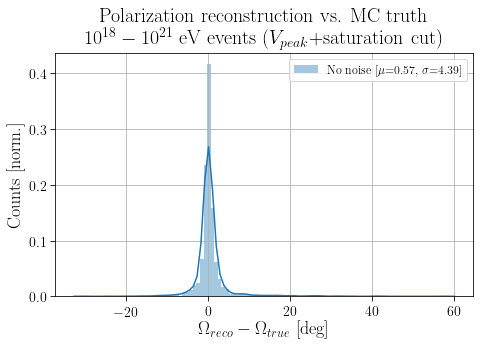

In [66]:
plt.figure(figsize=(7,5))
# plt.hist(recoNu.AngStokes-np.degrees(np.arccos(abs(recoNu.pol_z))), bins=100, density=False, alpha=1);
delta_std = (delta).std()
delta_mean = (delta).mean()
sns.distplot((delta), bins=100,label = "No noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\Omega_{reco}-\Omega_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm.]')
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events (no cuts)")
plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events ($V_{peak}$+saturation cut)")

# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_Cuts_noAbs.png', dpi=150)


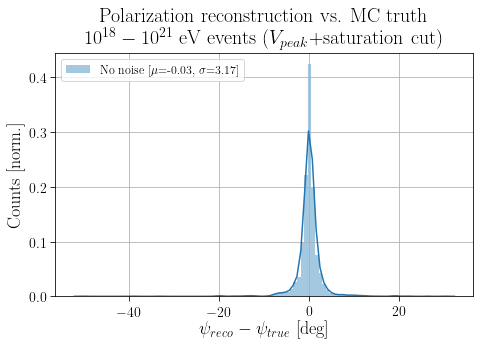

In [67]:
plt.figure(figsize=(7,5))
# plt.hist(recoNu.AngStokes-np.degrees(np.arccos(abs(recoNu.pol_z))), bins=100, density=False, alpha=1);
delta_std = (deltaPhi).std()
delta_mean = (deltaPhi).mean()
sns.distplot((deltaPhi), bins=100,label = "No noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\psi_{reco}-\psi_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm.]')
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events (no cuts)")
plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events ($V_{peak}$+saturation cut)")

# plt.yscale("log")
# mplcyberpunk.add_glow_effects()
# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_Cuts.png', dpi=150)


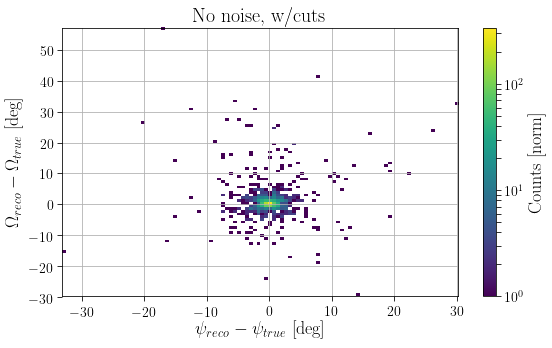

In [60]:
plt.figure(figsize=(8,5))
plt.hist2d(deltaPhi,delta, bins=100, normed=False,norm=mpl.colors.LogNorm());
# plt.hist2d(90-recoNu_noise.AngStokes,recoNu_noise.AngStokes-recoNu_noise.theta_pol, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.title("No noise, no cuts")
plt.title("No noise, w/cuts")
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.grid()
plt.colorbar(label="Counts [norm]")
plt.ylabel("$\Omega_{reco}-\Omega_{true}$ [deg]")
plt.xlabel("$\psi_{reco}-\psi_{true}$ [deg]")
# plt.title("$10^{21}$ eV neutrinos")
plt.tight_layout()
# plt.xlim(0,90)
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_Cuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsReco_AraSim_noiseless_noCuts.png', dpi=150)

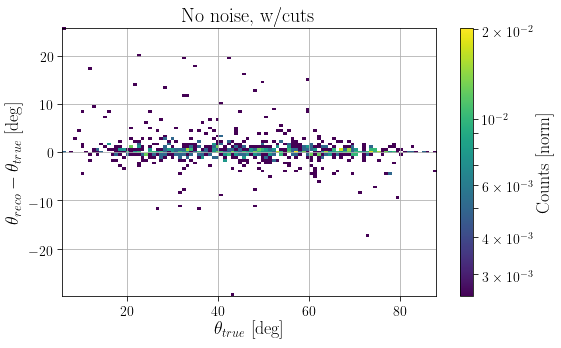

In [54]:
plt.figure(figsize=(8,5))
plt.hist2d(thetaPol_true,delta, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.hist2d(90-recoNu_noise.AngStokes,recoNu_noise.AngStokes-recoNu_noise.theta_pol, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.title("No noise, no cuts")
plt.title("No noise, w/cuts")
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.grid()
plt.colorbar(label="Counts [norm]")
plt.xlabel("$\\theta_{true}$ [deg]")
plt.ylabel("$\\theta_{reco}-\\theta_{true}$ [deg]")
# plt.title("$10^{21}$ eV neutrinos")
plt.tight_layout()
# plt.xlim(0,90)
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_Cuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsReco_AraSim_noiseless_noCuts.png', dpi=150)

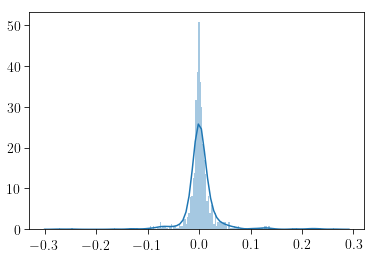

In [45]:
sns.distplot(abs(Pz_true)-abs(Pz_reco), bins = 200);

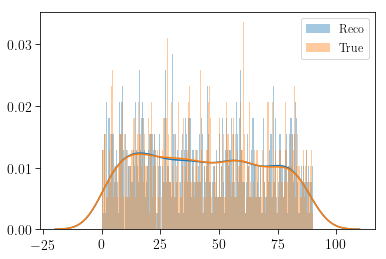

In [46]:
# Pz_true = Pz_true[Pz_true<0]
sns.distplot(phiPol_reco, bins=200, label = "Reco");
sns.distplot(phiPol_true, bins=200, label = "True");
plt.legend()

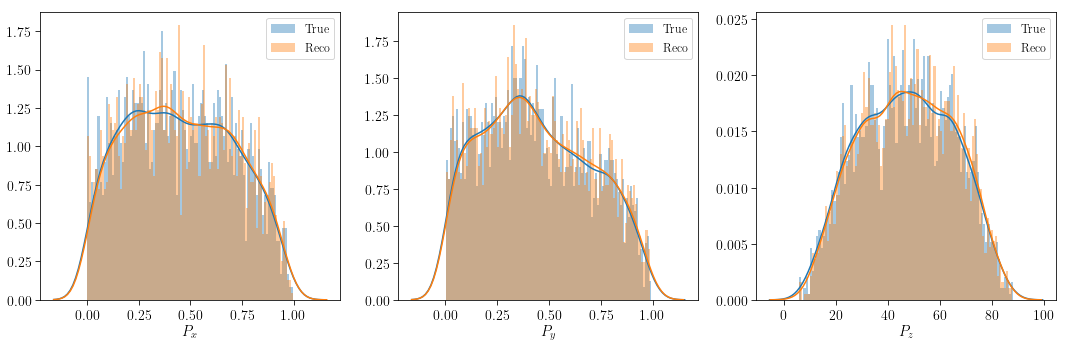

In [70]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
f, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.distplot(abs(Px_true), bins=100, label= "True", ax=axes[0]);
sns.distplot(abs(Px_reco), bins=100, label= "Reco", ax=axes[0]);
axes[0].set_xlabel("$P_x$", fontsize=15)
# sns.legend()
axes[0].legend()

sns.distplot(abs(Py_true), bins=100, label= "True", ax=axes[1]);
sns.distplot(abs(Py_reco), bins=100, label= "Reco", ax=axes[1]);
axes[1].set_xlabel("$P_y$", fontsize=15)
# sns.legend()
axes[1].legend()

sns.distplot(np.degrees(np.arccos(abs(Pz_true))), bins=100, label= "True", ax=axes[2]);
sns.distplot(np.degrees(np.arccos((Pz_reco))), bins=100,label= "Reco", ax=axes[2]);
axes[2].set_xlabel("$P_z$", fontsize=15)
axes[2].legend()

plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_PxPyPz.png', dpi=150)


Text(0.5,0,'$\\phi_{antenna}$')

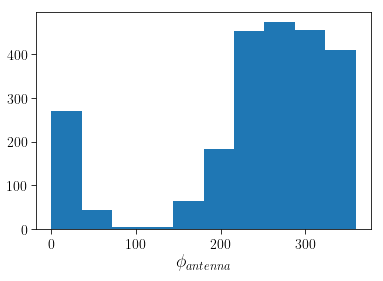

In [69]:
plt.hist(np.degrees(recoNu.phi_reco));
# plt.hist(np.degrees(wrapped.phi_reco));
# plt.hist(np.degrees(wrapped2.phi_reco));


plt.xlabel("$\phi_{antenna}$")

In [23]:
wrapped = recoNu.loc[recoNu.phi_reco>np.pi]
wrapped.phi_reco = wrapped.phi_reco-np.pi
wrapped2 = recoNu.loc[recoNu.phi_reco<np.pi]
